In [156]:
# Importing libraries 
import pandas as pd
import numpy as np
import gspread
from oauth2client.service_account import ServiceAccountCredentials
import matplotlib.pyplot as plt
import seaborn as sns
import links as lk
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

### Google Sheets Sign-Up

In [157]:
# Set Up Authentication for google sheets
scope = ["https://spreadsheets.google.com/feeds", "https://www.googleapis.com/auth/drive"]
creds = ServiceAccountCredentials.from_json_keyfile_name("credentials.json", scope)
client = gspread.authorize(creds)

# Open Google Sheet by URL
sheet_url = lk.sheet_url
sheet = client.open_by_url(sheet_url).sheet1  # Second sheet for preparing the models only 

# Convert Sheet Data to Pandas DataFrame
data = sheet.get_all_values()
df = pd.DataFrame(data)

### Data Cleaning

In [158]:
# Set First Row as Column Names
df.columns = df.iloc[0]  # Assign first row as headers
df = df[1:]  # Remove the first row from data

# Drop Unnecessary Columns
df = df.drop(df.columns[11:], axis=1)  # Drop all columns from index 9 onward
print("Column names:", df.columns.tolist())  # Check the column names

df.head()

Column names: ['Timestamp', 'Device', 'Temperature (C)', 'Temperature (F)', 'Humidity', 'Co2', 'ADC', 'Voltage', 'Pressure', 'Airspeed', 'Occupancy']


,Timestamp,Device,Temperature (C),Temperature (F),Humidity,Co2,ADC,Voltage,Pressure,Airspeed,Occupancy
1,2025-03-24 00:28:27,Pico_1,26.2,79.16,62.8,1470.098,N/A,N/A,N/A,N/A,3
2,2025-03-24 00:28:50,Pico_1,26.2,79.16,61.9,832.6554,N/A,N/A,N/A,N/A,3
3,2025-03-24 00:33:46,Pico_1,25.6,78.08,59.6,1549.979,N/A,N/A,N/A,N/A,3
4,2025-03-24 00:34:15,Pico_1,25.3,77.54,58.4,0,N/A,N/A,N/A,N/A,3
5,2025-03-24 00:34:25,Pico_1,25.3,77.54,58.4,0,N/A,N/A,N/A,N/A,3


In [159]:
# Dropping Columns not used in this model analysis 
df = df.drop(df.columns[6:], axis=1)
df = df.drop('Device', axis=1)  
df.head()

,Timestamp,Temperature (C),Temperature (F),Humidity,Co2
1,2025-03-24 00:28:27,26.2,79.16,62.8,1470.098
2,2025-03-24 00:28:50,26.2,79.16,61.9,832.6554
3,2025-03-24 00:33:46,25.6,78.08,59.6,1549.979
4,2025-03-24 00:34:15,25.3,77.54,58.4,0
5,2025-03-24 00:34:25,25.3,77.54,58.4,0


In [160]:
# Dropping columns which were used for testing the sensors 
df = df.drop(index=range(1, 11)).reset_index(drop=True)
df.head()

,Timestamp,Temperature (C),Temperature (F),Humidity,Co2
0,2025-03-24 00:51:28,26,78.8,93.1,215.3802
1,2025-03-24 00:51:51,26.1,78.98,92.9,474.9321
2,2025-03-24 00:52:14,26.3,79.34,91.7,244.8746
3,2025-03-24 00:52:37,26.5,79.7,90.9,430.0756
4,2025-03-24 00:53:00,26.7,80.06,90.6,380.2175


In [161]:
# List of variables
vars_to_clean = ['Temperature (C)', 'Temperature (F)', 'Humidity', 'Co2']

# Convert Timestamp to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Clean and convert each variable
for v in vars_to_clean:
    df[v] = pd.to_numeric(df[v].replace(['', ' ', 'N/A'], '0'), errors='coerce').fillna(0)


In [162]:
# Converting N/A values to 0 and changing data types
var = ['Temperature (C)','Temperature (F)', 'Humidity', 'Co2']
df['Timestamp'] = pd.to_datetime(df['Timestamp']) # Convert Timestamp to datetime
for var in var:
    df[var] = df[var].astype(float)  # Replace N/A with 0 and convert to float
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3966 entries, 0 to 3965
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Timestamp        3966 non-null   datetime64[ns]
 1   Temperature (C)  3966 non-null   float64       
 2   Temperature (F)  3966 non-null   float64       
 3   Humidity         3966 non-null   float64       
 4   Co2              3966 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 155.1 KB


#### Creating a batch for forecasting

In [163]:
# Creating a column to differentiate between the timings of the data
df["Time_Diff"] = df["Timestamp"].diff().dt.total_seconds() # Calculate time difference between rows
df["Batch"] = (df["Time_Diff"] > 120).cumsum() # Create batch number based on time difference
df = df.drop(columns=["Time_Diff"])         # Drop the time difference column
latest_batch = df["Batch"].max()          # Get the latest batch number
data = df[df["Batch"] == latest_batch].copy() # Filter the latest batch data
data.head()

,Timestamp,Temperature (C),Temperature (F),Humidity,Co2,Batch
2327,2025-03-24 22:20:05,28.6,83.48,84.0,439.931400,6
2328,2025-03-24 22:21:00,28.5,83.30,84.4,485.040700,6
2329,2025-03-24 22:21:24,28.6,83.48,84.5,474.973900,6
2330,2025-03-24 22:21:48,28.6,83.48,84.4,444.983900,6
2331,2025-03-24 22:22:11,28.6,83.48,84.4,7.634521,6


#### Dropping unecessary CO2 columns 

In [164]:
# Identify rows to drop based on the condition in CO2 column
drop_indices = []

for i in range(1, len(data) - 1):  # Start from index 1 to avoid out-of-bounds errors
    if data['Co2'].iloc[i] < 250: 
        drop_indices.append(data.index[i])  # Store index to drop

# Drop the identified rows which
data = data.drop(index=drop_indices).reset_index(drop=True)
data.head()

,Timestamp,Temperature (C),Temperature (F),Humidity,Co2,Batch
0,2025-03-24 22:20:05,28.6,83.48,84.0,439.9314,6
1,2025-03-24 22:21:00,28.5,83.30,84.4,485.0407,6
2,2025-03-24 22:21:24,28.6,83.48,84.5,474.9739,6
3,2025-03-24 22:21:48,28.6,83.48,84.4,444.9839,6
4,2025-03-24 22:22:35,28.6,83.48,84.4,414.9689,6


### Data Visualization

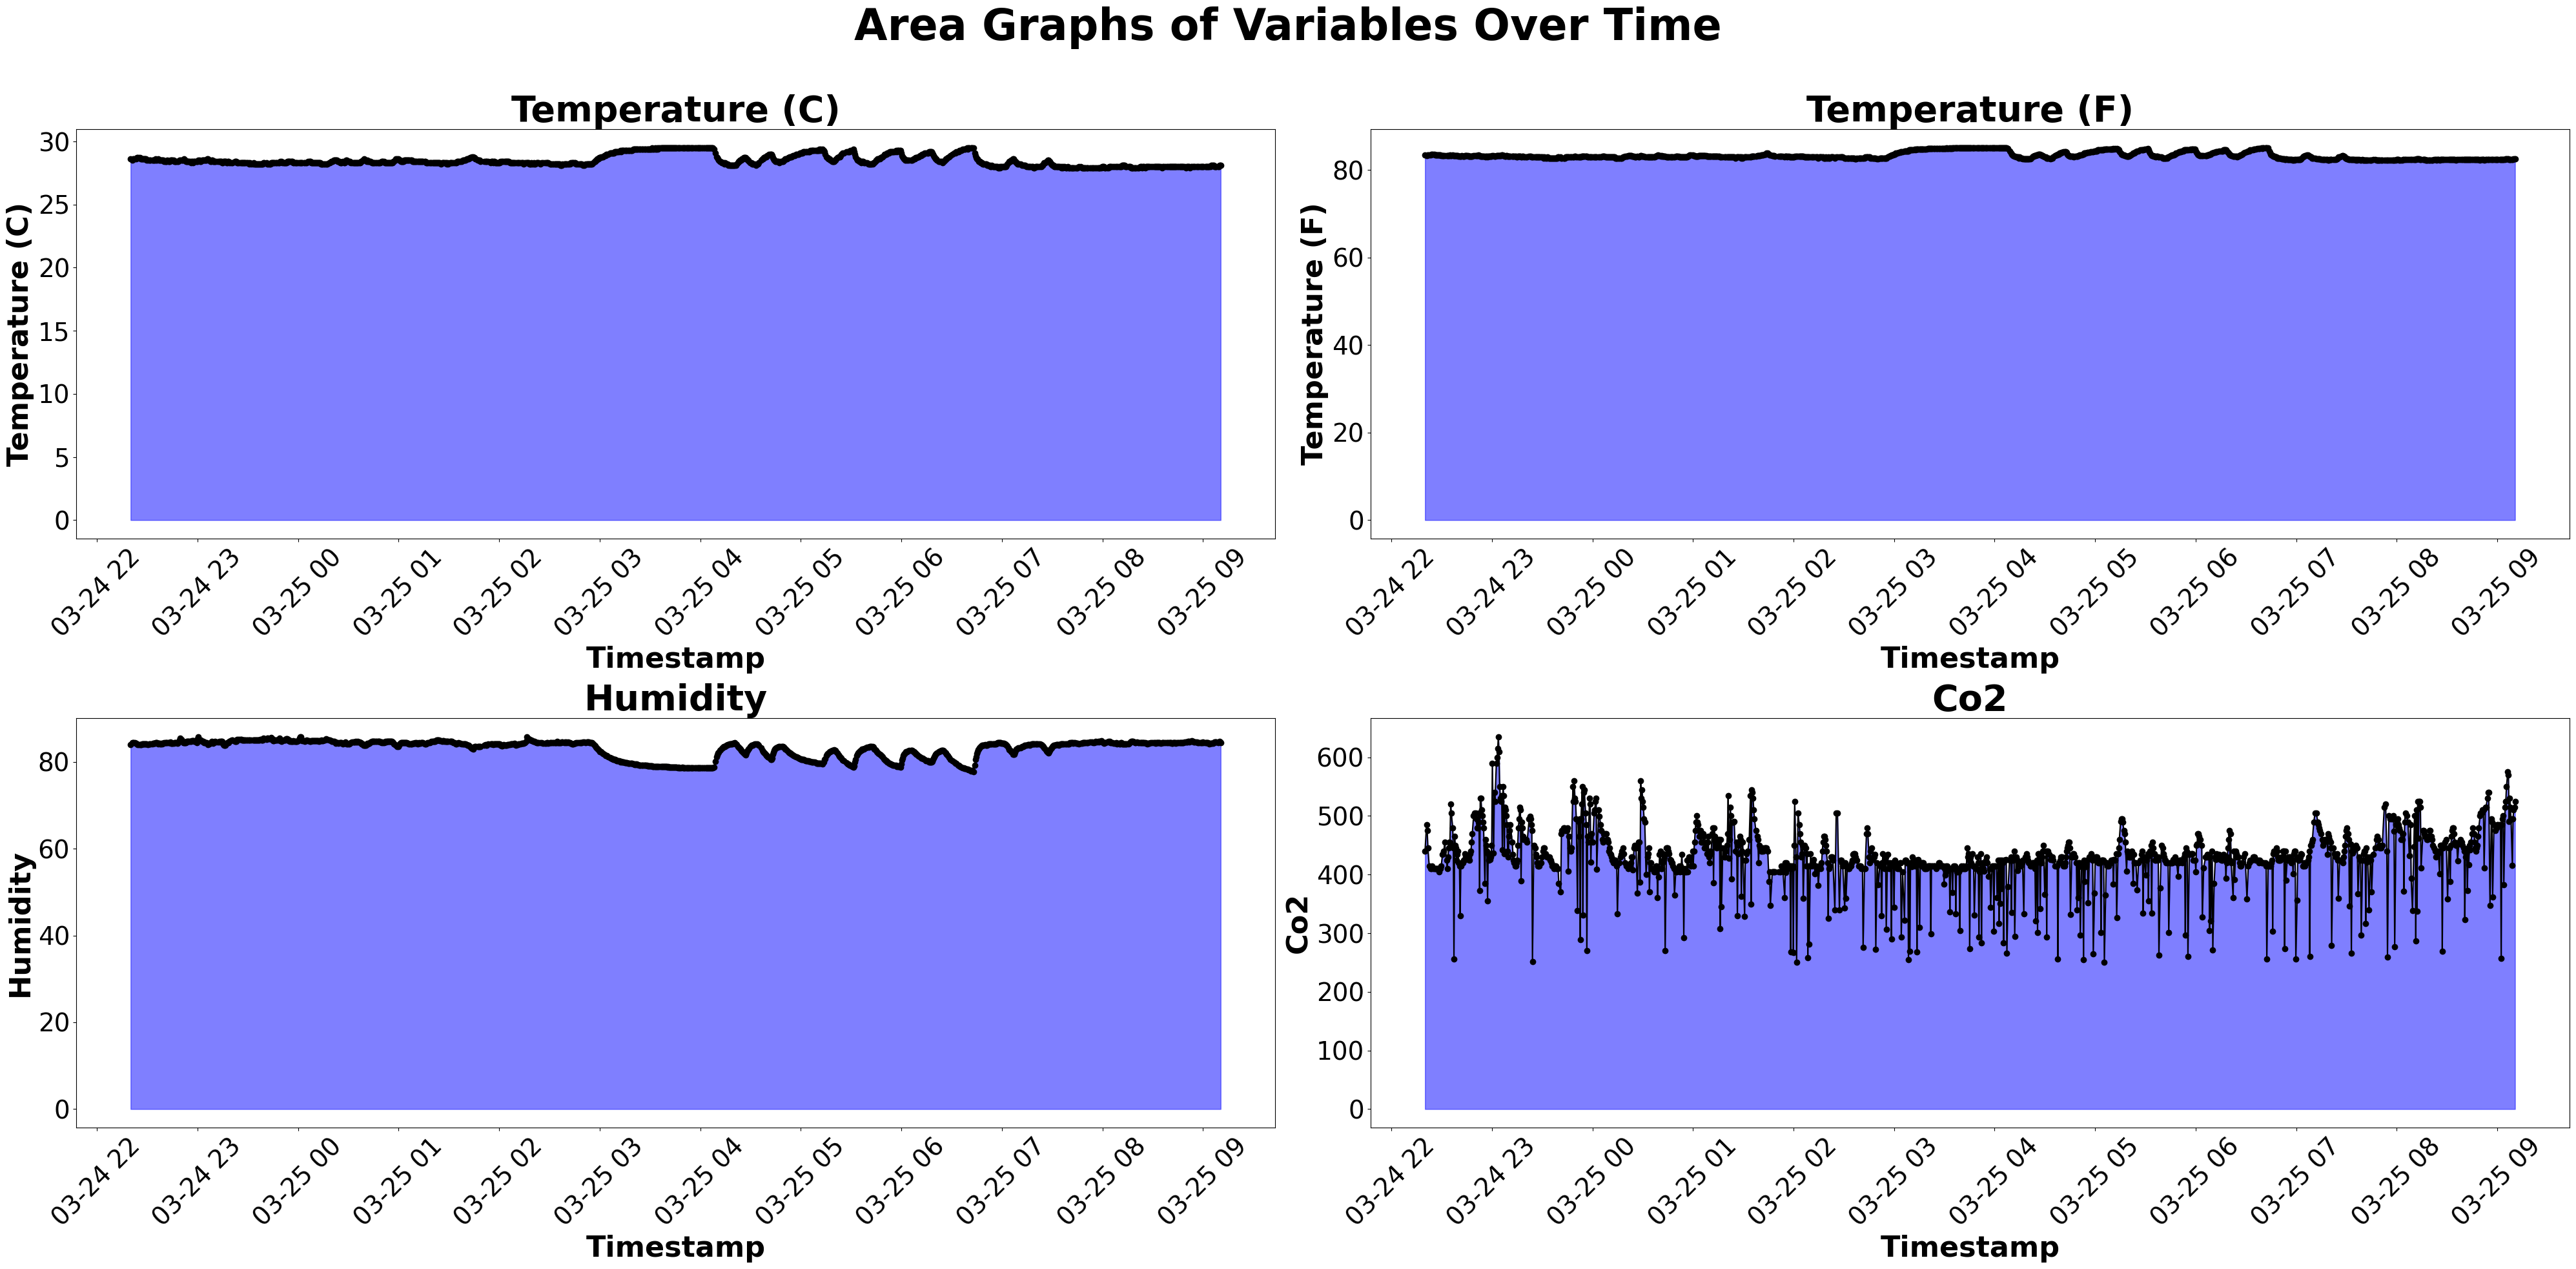

In [165]:
# Create 2x2 subplots with a larger figure size
fig, axes = plt.subplots(2, 2, figsize=(40, 20))
fig.suptitle("Area Graphs of Variables Over Time", fontsize=48, fontweight='bold')

# Flatten axes array for easy iteration
axes = axes.flatten()
variables = ["Temperature (C)", "Temperature (F)", "Humidity", "Co2"]

# Plot each variable
for i, var in enumerate(variables):
    ax = axes[i]
    ax.fill_between(data["Timestamp"], data[var], alpha=0.5, color="blue")
    ax.plot(data["Timestamp"], data[var], marker="o", linestyle="-", color="black")

    # Styling
    ax.set_title(var, fontsize=40, fontweight='bold')
    ax.set_xlabel("Timestamp", fontsize=32, fontweight='bold')
    ax.set_ylabel(var, fontsize=32, fontweight='bold')
    ax.tick_params(axis='x', rotation=45, labelsize=28)
    ax.tick_params(axis='y', labelsize=28)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


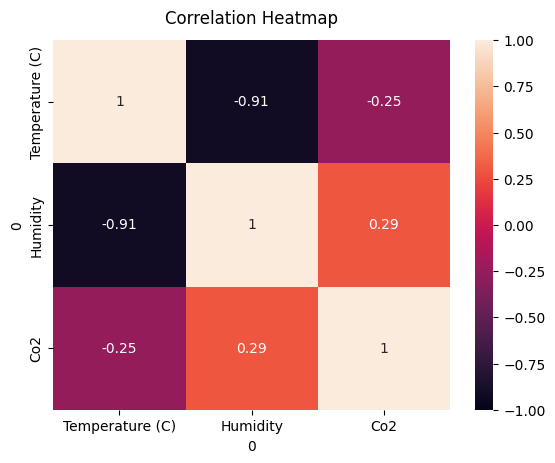

In [166]:
x = ['Temperature (C)', 'Humidity', 'Co2']
heatmap = sns.heatmap(data[x].corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)
plt.show()

#### Models

##### Wells-Riley Infection (Covid-19)

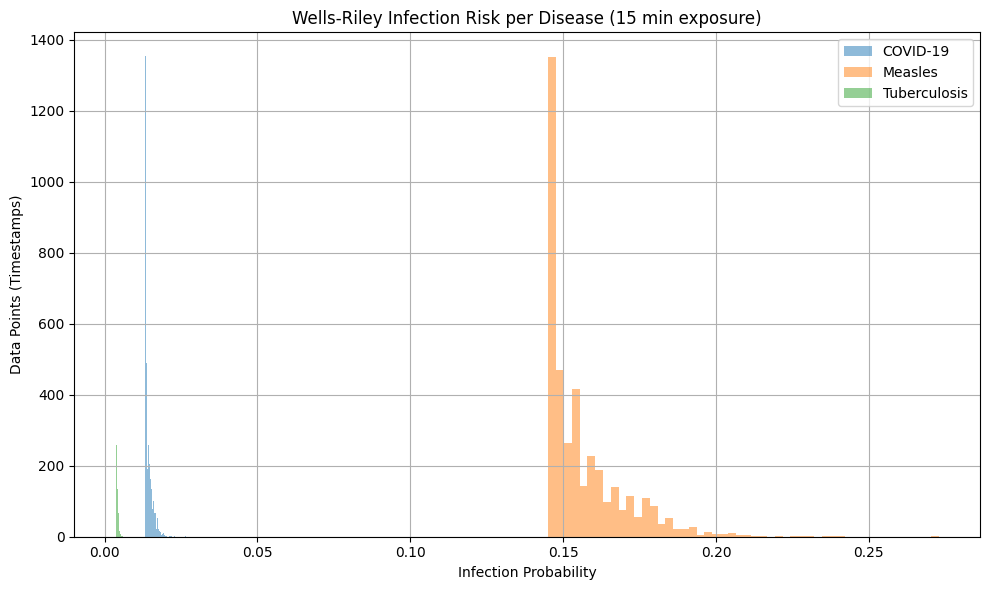

Average Infection Risk (15 min exposure):
   COVID-19: 1.42%
   Measles: 15.62%
   Tuberculosis: 0.39%


,Timestamp,Temperature (C),Temperature (F),Humidity,Co2,Batch,Ventilation (Q),COVID-19 Risk,Measles Risk,Tuberculosis Risk
0,2025-03-24 00:51:28,26.0,78.80,93.1,215.3802,0,30.299252,0.013117,0.145126,0.003570
1,2025-03-24 00:51:51,26.1,78.98,92.9,474.9321,0,25.582604,0.015517,0.169486,0.004227
2,2025-03-24 00:52:14,26.3,79.34,91.7,244.8746,0,30.299252,0.013117,0.145126,0.003570
3,2025-03-24 00:52:37,26.5,79.70,90.9,430.0756,0,28.250847,0.014062,0.154790,0.003828
4,2025-03-24 00:53:00,26.7,80.06,90.6,380.2175,0,30.299252,0.013117,0.145126,0.003570


In [167]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# STEP 1: Parameters
V = 5.0625           # Room volume in m³ (lift cabin)
t = 0.01667          # Exposure time in hours (15 mins)
p = 0.5           # Pulmonary ventilation rate in m³/h (quiet breathing)
I = 1             # One infectious person assumed

# Disease-specific quanta generation rates (q) [quanta/hour]
q_disease = {
    'COVID-19': 48,
    'Measles': 570,
    'Tuberculosis': 13
}

# STEP 2: Estimate Ventilation Rate (Q) from CO₂
# Assume baseline outdoor CO₂ = 400 ppm
# ACH is inversely proportional to CO₂ buildup
def estimate_Q_from_co2(co2_ppm, V=12):
    co2_ppm = np.maximum(co2_ppm, 401)  # avoid divide by 0
    ach = 6 * (400 / co2_ppm)           # proxy: higher CO₂ → lower ACH
    Q = V * ach                         # Convert ACH to ventilation in m³/h
    return Q

# STEP 3: Wells-Riley function
def wells_riley(I, q, p, t, Q):
    return 1 - np.exp(-I * q * p * t / Q)

# STEP 4: Apply to dataset
df['Ventilation (Q)'] = df['Co2'].apply(lambda x: estimate_Q_from_co2(x, V))

# STEP 5: Compute infection probabilities for all diseases
for disease, q in q_disease.items():
    df[f'{disease} Risk'] = df['Ventilation (Q)'].apply(lambda Q: wells_riley(I, q, p, t, Q))

# STEP 6: Visualize infection risk comparison
plt.figure(figsize=(10, 6))
for disease in q_disease:
    plt.hist(df[f'{disease} Risk'], bins=50, alpha=0.5, label=disease)

plt.xlabel("Infection Probability")
plt.ylabel("Data Points (Timestamps)")
plt.title("Wells-Riley Infection Risk per Disease (15 min exposure)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# STEP 7: Average infection risk per disease (optional summary)
avg_risk = {disease: df[f'{disease} Risk'].mean() for disease in q_disease}
print("Average Infection Risk (15 min exposure):")
for disease, risk in avg_risk.items():
    print(f"   {disease}: {risk:.2%}")

df.head()


##### Ventilation Effectiveness (Decay Model): Exponential decay of CO₂ post-trip

                     k (decay rate)          C0
Hour                                           
2025-03-24 22:00:00       -0.649246   24.346761
2025-03-24 23:00:00        0.809149  130.178525
2025-03-25 00:00:00        1.067534   80.448561
2025-03-25 01:00:00        0.546261   67.573642
2025-03-25 02:00:00        0.838024   33.371299
2025-03-25 03:00:00       21.968089   31.257731
2025-03-25 04:00:00       -0.345599    4.511440
2025-03-25 06:00:00        0.201180   24.486504
2025-03-25 08:00:00       -0.062708   52.813929


/var/folders/zl/2t5vnbxd1pl_tjbrjjs5mzp80000gn/T/ipykernel_84304/893286797.py:34: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  for hour, group in data['Co2'].resample('1H'):
/var/folders/zl/2t5vnbxd1pl_tjbrjjs5mzp80000gn/T/ipykernel_84304/893286797.py:38: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  group = group.fillna(method='ffill').rolling(5, min_periods=1).mean()


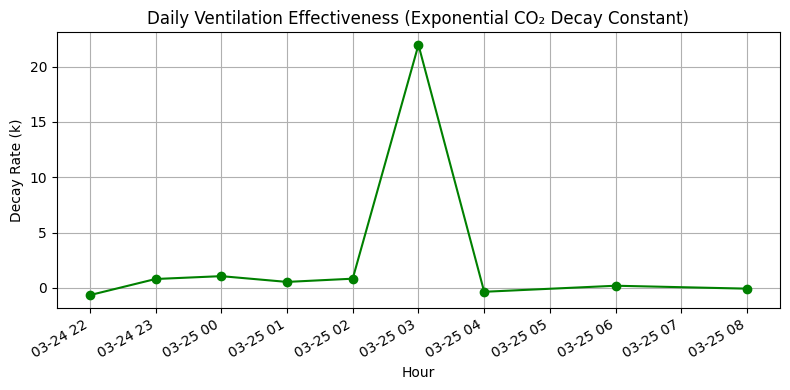

In [169]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# --- SETTINGS ---
C_baseline = 400  # ppm assumed background CO₂
t_unit = 60       # seconds between sensor readings (adjust if needed)

# --- MODEL ---
def co2_decay_model(t, C0, k):
    return C0 * np.exp(-k * t) + C_baseline

# --- FITTING FUNCTION ---
def fit_decay(time_series, co2_series):
    t = np.arange(len(co2_series)) * (t_unit / 60) / 60  # convert to hours
    co2_excess = co2_series - C_baseline
    p0 = [np.max(co2_excess), 1.0]

    try:
        popt, _ = curve_fit(co2_decay_model, t, co2_series, p0=p0, maxfev=5000)
        C0_fit, k_fit = popt
        return k_fit, C0_fit
    except:
        return np.nan, np.nan

# --- STEP 1: Timestamp prep ---
# data['Timestamp'] = pd.to_datetime(data['Timestamp'])
# data = data.set_index('Timestamp')

# --- STEP 2: Grouping (daily decay) ---
hourly_decay = []

for hour, group in data['Co2'].resample('1H'):
    if len(group) < 20 or group.isna().mean() > 0.5:
        continue
    # Optional smoothing
    group = group.fillna(method='ffill').rolling(5, min_periods=1).mean()

    # Only fit if decay pattern detected
    if group.iloc[0] > group.iloc[-1]:
        k, C0 = fit_decay(group.index, group.values)
        if not np.isnan(k):
            hourly_decay.append({'Hour': hour, 'k (decay rate)': k, 'C0': C0})


# --- STEP 3: Results & Plot ---
vent_df = pd.DataFrame(hourly_decay).set_index('Hour')
print(vent_df)

# Visualize daily ventilation quality
plt.figure(figsize=(8, 4))
vent_df['k (decay rate)'].plot(marker='o', color='green')
plt.ylabel("Decay Rate (k)")
plt.title("Daily Ventilation Effectiveness (Exponential CO₂ Decay Constant)")
plt.grid(True)
plt.tight_layout()
plt.show()


Higher k = faster CO₂ decay → better ventilation

Lower k (near 0) = slow or no decay → poor ventilation

Negative k = possibly data noise, misfit, or CO₂ rising (not decaying)

#### Viral Stability Score (Environmental Viability Model)

/var/folders/zl/2t5vnbxd1pl_tjbrjjs5mzp80000gn/T/ipykernel_84304/4015039961.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='COVID Stability', order=['Low', 'Medium', 'High'], ax=axs[0], palette=colors, legend=False)
/var/folders/zl/2t5vnbxd1pl_tjbrjjs5mzp80000gn/T/ipykernel_84304/4015039961.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Measles Stability', order=['Low', 'Medium', 'High'], ax=axs[1], palette=colors, legend=False)
/var/folders/zl/2t5vnbxd1pl_tjbrjjs5mzp80000gn/T/ipykernel_84304/4015039961.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and s

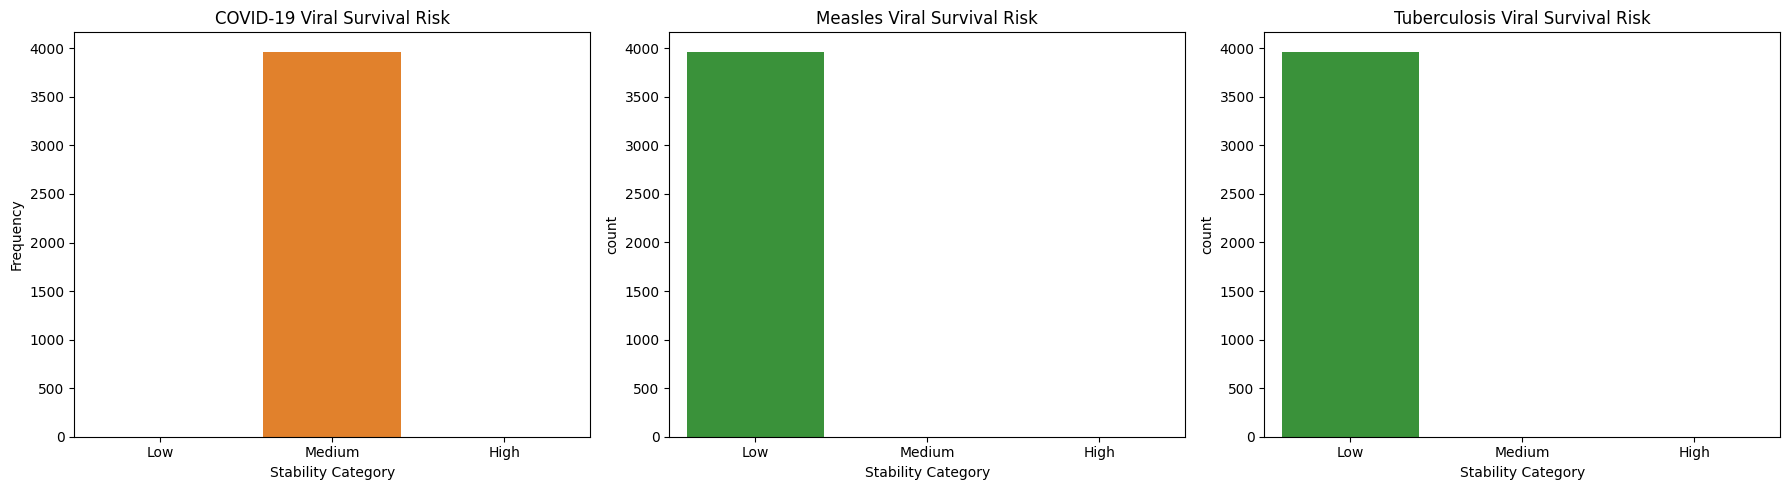

In [191]:
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Define per-disease viral stability category functions ---

def covid_stability_category(temp_c, rh_percent):
    if temp_c < 20 and (rh_percent < 40 or rh_percent > 60):
        return 'High'
    elif temp_c < 20 or (rh_percent < 40 or rh_percent > 60):
        return 'Medium'
    else:
        return 'Low'

def measles_stability_category(temp_c, rh_percent):
    if temp_c < 21 and rh_percent < 50:
        return 'High'
    elif temp_c < 21 or rh_percent < 50:
        return 'Medium'
    else:
        return 'Low'

def tb_stability_category(temp_c, rh_percent):
    if temp_c < 25 and rh_percent < 50:
        return 'High'
    elif temp_c < 25 or rh_percent < 50:
        return 'Medium'
    else:
        return 'Low'

# --- 2. Apply each model to your DataFrame ---

df['COVID Stability'] = df.apply(
    lambda row: covid_stability_category(row['Temperature (C)'], row['Humidity']), axis=1
)

df['Measles Stability'] = df.apply(
    lambda row: measles_stability_category(row['Temperature (C)'], row['Humidity']), axis=1
)

df['TB Stability'] = df.apply(
    lambda row: tb_stability_category(row['Temperature (C)'], row['Humidity']), axis=1
)

# --- 3. Optional: Plot each one ---

colors = {
    'Low': '#2ca02c',     # green
    'Medium': '#ff7f0e',  # orange
    'High': '#d62728'     # red
}

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

sns.countplot(data=df, x='COVID Stability', order=['Low', 'Medium', 'High'], ax=axs[0], palette=colors, legend=False)
axs[0].set_title('COVID-19 Viral Survival Risk')
axs[0].set_ylabel("Frequency")
axs[0].set_xlabel("Stability Category")

sns.countplot(data=df, x='Measles Stability', order=['Low', 'Medium', 'High'], ax=axs[1], palette=colors, legend=False)
axs[1].set_title('Measles Viral Survival Risk')
axs[1].set_xlabel("Stability Category")

sns.countplot(data=df, x='TB Stability', order=['Low', 'Medium', 'High'], ax=axs[2], palette=colors, legend=False)
axs[2].set_title('Tuberculosis Viral Survival Risk')
axs[2].set_xlabel("Stability Category")

plt.tight_layout()
plt.show()


Covid - 19 --> \
Low Temp (< 20°C) → higher virus survival \
RH < 40% or > 60% → increased aerosol stability \
Conclusion: There is high risk of aerosol statbility as the humidity is always above 75% and low risk for virus survival as the temperature over 26°C. Overall, Covid-19 is a medium risk disease. 

Tuberculosis --> \
Temp (< 25°C) → higher virus survival \
RH < 50% → increased aerosol stability \
Conclusion: There is low risk of aerosol statbility as the humidity is always above 75% and low risk for virus survival as the temperature over 26°C. Overall, Tuberculosis is a low risk disease. 

Measles -->  \
Temp (< 21°C) → higher virus survival \ 
RH < 50% → increased aerosol stability \
Conclusion: There is low risk of aerosol statbility as the humidity is always above 75% and low risk for virus survival as the temperature over 26°C. Overall, Measles is a low risk disease. 

#### Thermal Comfort Model - Based on Ashare comfort zone 

In [171]:
def thermal_comfort_score(temp_c, rh_percent):
    if 22 <= temp_c <= 26 and 30 <= rh_percent <= 70:
        return 0
    if ((24 <= temp_c < 26 or 26 < temp_c <= 29) and (20 <= rh_percent <= 80)) or \
       ((24 <= temp_c <= 28) and (60 < rh_percent <= 85)):
        return 1
    return 2

# Apply row-wise using lambda
df['Comfort Score'] = df.apply(lambda row: thermal_comfort_score(row['Temperature (C)'], row['Humidity']), axis=1)
df.head()

,Timestamp,Temperature (C),Temperature (F),Humidity,Co2,Batch,Ventilation (Q),COVID-19 Risk,Measles Risk,Tuberculosis Risk,COVID Stability,Measles Stability,TB Stability,Comfort Score
0,2025-03-24 00:51:28,26.0,78.80,93.1,215.3802,0,30.299252,0.013117,0.145126,0.003570,Medium,Low,Low,2
1,2025-03-24 00:51:51,26.1,78.98,92.9,474.9321,0,25.582604,0.015517,0.169486,0.004227,Medium,Low,Low,2
2,2025-03-24 00:52:14,26.3,79.34,91.7,244.8746,0,30.299252,0.013117,0.145126,0.003570,Medium,Low,Low,2
3,2025-03-24 00:52:37,26.5,79.70,90.9,430.0756,0,28.250847,0.014062,0.154790,0.003828,Medium,Low,Low,2
4,2025-03-24 00:53:00,26.7,80.06,90.6,380.2175,0,30.299252,0.013117,0.145126,0.003570,Medium,Low,Low,2


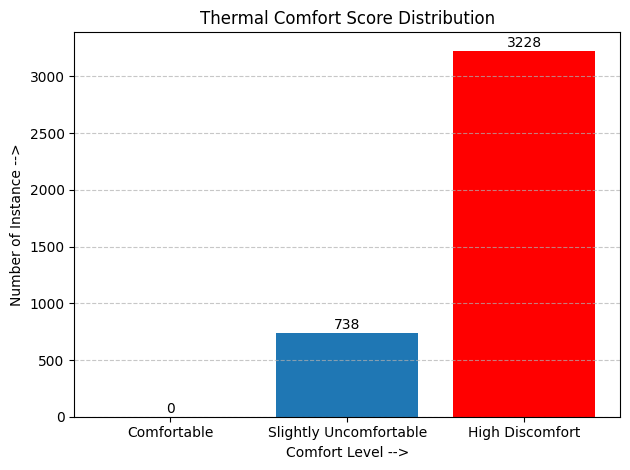

In [173]:
import matplotlib.pyplot as plt

# Count scores and ensure all categories are represented
score_labels = {0: "Comfortable", 1: "Slightly Uncomfortable", 2: "High Discomfort"}
score_counts = df['Comfort Score'].value_counts().sort_index()

# Fill missing score categories with 0
for score in score_labels:
    if score not in score_counts:
        score_counts[score] = 0

score_counts = score_counts.sort_index()

# Assign colors: red for 'High Discomfort' (score 2)
colors = ['#1f77b4', '#1f77b4', 'red']

# Plot
bars = plt.bar(score_counts.index, score_counts.values, 
               tick_label=[score_labels[s] for s in score_counts.index],
               color=colors)

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 10, f'{int(height)}', 
             ha='center', va='bottom', fontsize=10)

# Labels & styling
plt.xlabel("Comfort Level -->")
plt.ylabel("Number of Instance -->")
plt.title("Thermal Comfort Score Distribution")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


As Singapore is a Tropical Country, the humidity and temperature levels are high, therefore, it is creating uncomfortable environment in lift. Especially, as it is also a naturally ventilated lift. 

#### Anomaly Detection in CO₂ Patterns Model

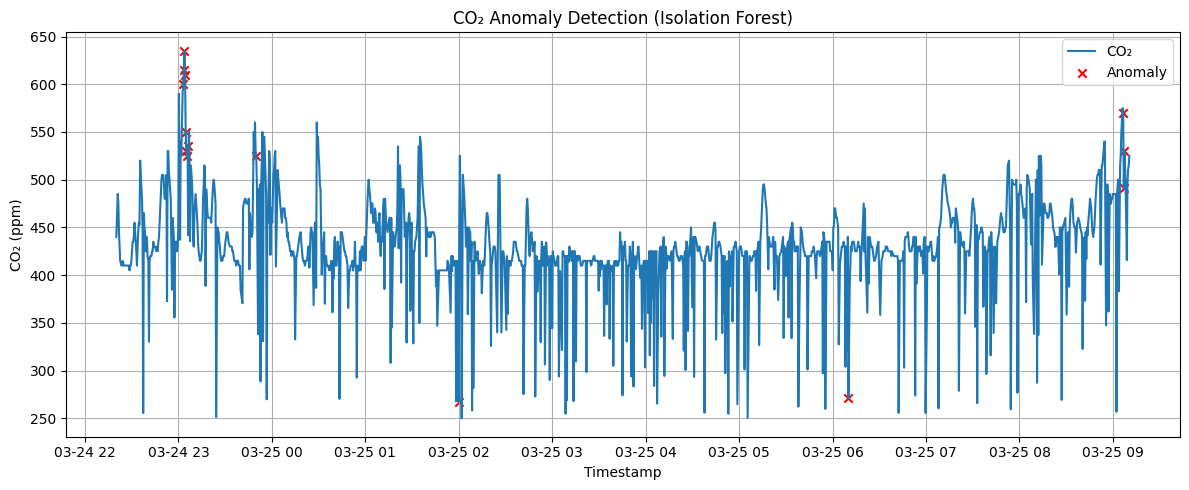

Total anomalies detected: 40


In [176]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt

# --- STEP 1: Timestamp prep (if needed) ---
# data['Timestamp'] = pd.to_datetime(data['Timestamp'])
# data = data.set_index('Timestamp')

# --- STEP 2: Feature engineering for CO₂ trends ---
# Optionally smooth or compute rolling average for more stable features
data['Co2_Smooth'] = data['Co2'].rolling(window=5, min_periods=1).mean()

# You can also create lagged features or CO₂ deltas if needed
# df['Co2_Delta'] = df['Co2'].diff()

# --- STEP 3: Isolation Forest ---
model = IsolationForest(contamination=0.01, random_state=42)  # 1% expected anomalies
data['Anomaly'] = model.fit_predict(data[['Co2_Smooth']])

# Map Isolation Forest output: -1 = anomaly, 1 = normal
data['Anomaly'] = data['Anomaly'].map({1: 0, -1: 1})  # 1 = Anomaly, 0 = Normal

# --- STEP 4: Visualization ---
plt.figure(figsize=(12, 5))
plt.plot(data.index, data['Co2'], label='CO₂')
plt.scatter(data[data['Anomaly'] == 1].index, data[data['Anomaly'] == 1]['Co2'],
            color='red', label='Anomaly', marker='x')
plt.title("CO₂ Anomaly Detection (Isolation Forest)")
plt.xlabel("Timestamp")
plt.ylabel("CO₂ (ppm)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- STEP 5: Summary ---
print("Total anomalies detected:", df['Anomaly'].sum())


Spikes at 03-24 23:00 and again near 03-25 09:00: \
These are likely overcrowding events, stuck lift scenarios, or moments of very poor ventilation, leading to rapid CO₂ accumulation. \

Sudden drops or flat-lining (03-25 06:00): \
May indicate sensor dropout, door stuck open, or sudden air flushing event. \

####  Time Series Clustering (Usage Profiling)

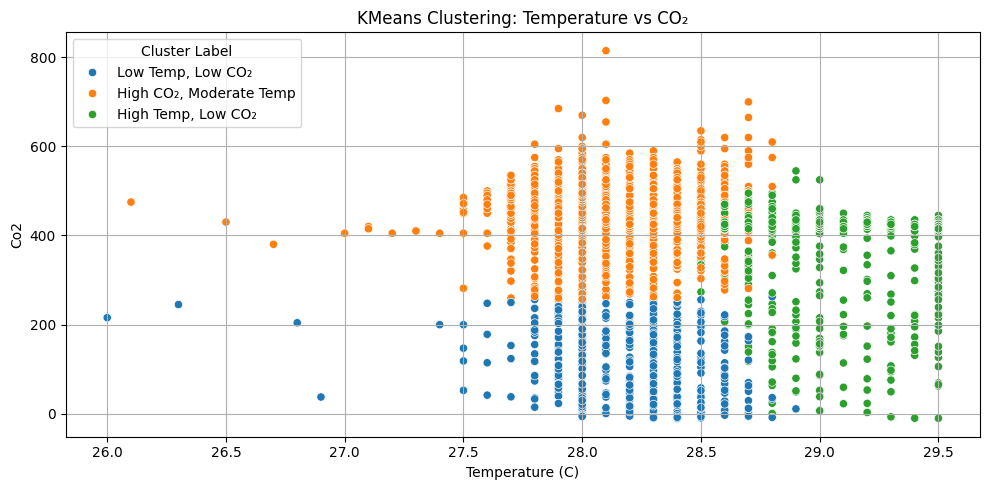

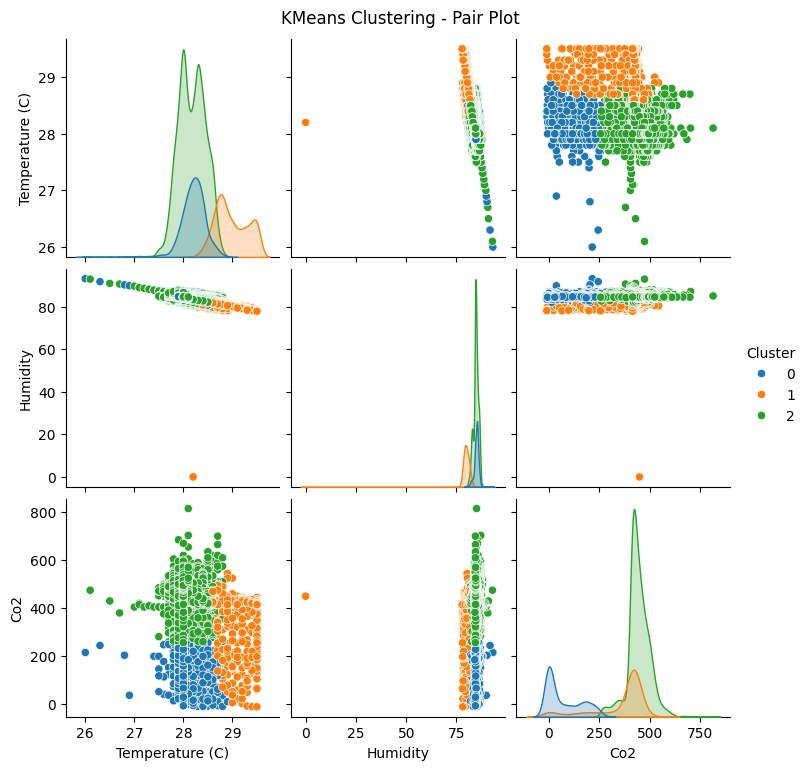

🔍 Cluster Centroids:
 0        Temperature (C)   Humidity         Co2
Cluster                                        
0              28.203547  84.845157   73.518872
1              28.976073  79.835891  355.142283
2              28.169156  84.572930  443.460906


In [181]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# STEP 1: Load and clean your data
# Ensure 'Timestamp' is datetime
# df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# STEP 2: Select features for clustering
features = df[['Temperature (C)', 'Humidity', 'Co2']].copy()

# Drop rows with missing values
features = features.dropna()

# STEP 3: Normalize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# STEP 4: Apply KMeans Clustering
k = 3  # you can change this based on elbow method
kmeans = KMeans(n_clusters=k, random_state=42)
df['Cluster'] = kmeans.fit_predict(scaled_features)

# STEP 4.5: Map cluster numbers to descriptive labels
label_map = {
    0: "Low Temp, Low CO₂",
    1: "High Temp, Low CO₂",
    2: "High CO₂, Moderate Temp"
}

df['Cluster Label'] = df['Cluster'].map(label_map)

# STEP 5: Visualize Cluster Assignments
plt.figure(figsize=(10, 5))
sns.scatterplot(data=df, x='Temperature (C)', y='Co2', hue='Cluster Label', palette='tab10')
plt.title('KMeans Clustering: Temperature vs CO₂')
plt.grid(True)
plt.tight_layout()
plt.show()

# Optional: Plot with humidity too
sns.pairplot(df, vars=['Temperature (C)', 'Humidity', 'Co2'], hue='Cluster', palette='tab10')
plt.suptitle("KMeans Clustering - Pair Plot", y=1.02)
plt.show()

# STEP 6: Cluster statistics (optional)
cluster_summary = df.groupby('Cluster')[['Temperature (C)', 'Humidity', 'Co2']].mean()
print("🔍 Cluster Centroids:\n", cluster_summary)


Cluster 0 (Low Temp, Low CO₂): These are likely periods of low or no occupancy, with good ventilation keeping CO₂ levels low.

Cluster 1 (High CO₂, Moderate Temp): This profile suggests poor ventilation or overcrowding — elevated CO₂ levels in a moderate thermal environment. These hours may correlate with peak usage or stuck lift scenarios.

Cluster 2 (High Temp, Low CO₂): While temperatures are high, the low CO₂ indicates good ventilation or short durations, potentially when the lift was hot but not occupied long enough to build CO₂.